# Predicting from separate data sources - AUDIO

... transformed to PCA

## Data preparation

In [12]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 67
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
#train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

# Divide the train dataset further into validation and train sets
# keeping in the val set a session from each teacher, 
# with a variety of tags for Activity and Social
#pandas.crosstab(index=data["session"], columns=data["Activity"])
#pandas.crosstab(index=data["session"], columns=data["Social"])
# e.g., case1-day1-session2-teacher1, case2-day2-session2-teacher2
print 'Loaded csvs'

Loaded csvs


In [13]:
val = notnull_data[notnull_data.session.isin(['case1-day1-session2-teacher1','case2-day2-session2-teacher2'])].values
print val.shape
tr = notnull_data[~notnull_data.session.isin(['case1-day1-session2-teacher1','case2-day2-session2-teacher2'])].values
print tr.shape

X_train = tr[:,3:7558].astype(float)
Y_trainA = tr[:,7558] #Activity
Y_trainS = tr[:,7559] #Social
X_val = val[:,3:7558].astype(float)
Y_valA = val[:,7558] #Activity
Y_valS = val[:,7559] #Social
X_test = test[:,3:7558].astype(float)
Y_testA = test[:,7558]
Y_testS = test[:,7559]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoderA = LabelEncoder()
encoderA.fit(Y_trainA)

encoded_Y_trainA = encoderA.transform(Y_trainA)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_trainA = to_categorical(encoded_Y_trainA)

encoded_Y_valA = encoderA.transform(Y_valA)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_valA = to_categorical(encoded_Y_valA)

#encoderA.fit(Y_testA)
encoded_Y_testA = encoderA.transform(Y_testA)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_testA = to_categorical(encoded_Y_testA)

# encode class values as integers
encoderS = LabelEncoder()
encoderS.fit(Y_trainS)
encoded_Y_trainS = encoderS.transform(Y_trainS)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_trainS = to_categorical(encoded_Y_trainS)

encoded_Y_valS = encoderS.transform(Y_valS)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_valS = to_categorical(encoded_Y_valS)

#encoderS.fit(Y_testS)
encoded_Y_testS = encoderS.transform(Y_testS)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_testS = to_categorical(encoded_Y_testS)

# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_val_st = scaler.transform(X_val)
X_test_st = scaler.transform(X_test)
print 'Split into train, val, test sets and scaled'

(969, 7560)
(3503, 7560)
Split into train, val, test sets and scaled


In [31]:
# Reduce the dataset to work with to the AUDIO variables
# Get the column names of the X matrix, to separate the different sources
colnamesX = list(data.columns.values)[3:7558]
# Eyetracking: colnamesX[0:10]
# Acc: colnamesX[10:150]
# Audio: colnamesX[150:6555]
# Video: colnamesX[6555:]
X_train_st_audio = X_train_st[:,150:6555]
X_val_st_audio = X_val_st[:,150:6555]
X_test_st_audio = X_test_st[:,150:6555]
# Number of components to extract from the dataset
n_components = 100

from sklearn import decomposition
print 'Reducing AUDIO dataset with PCA',n_components
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_st_audio)
X_val_pca = pca.transform(X_val_st_audio)
X_test_pca = pca.transform(X_test_st_audio)

#print 'Variance explained:'
#print pca.explained_variance_ratio_
print 'Total variance explained by %d components:',n_components
print sum(pca.explained_variance_ratio_)

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
valX = numpy.reshape(X_val_pca, (X_val_pca.shape[0], 1, X_val_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))


Reducing AUDIO dataset with PCA 100
Total variance explained by %d components: 100
0.684495816407


In [32]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.constraints import maxnorm
from keras.optimizers import SGD

# This is our winning architecture so far
def create_LSTM3_PCA(n_outputs, batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM2_PCA(n_outputs, batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(300, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM1_PCA(n_outputs, batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(400, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, cohen_kappa_score

def printValStats(model, testX, dummy_y_test, batch=1):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Kappa
    print('Kappa:')
    kappa = cohen_kappa_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    print(kappa)
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)
    return kappa, roc

def plot_training(accs, val_accs, losss, val_losss, kappas, aucs):
    # summarize history for accuracy
    plt.plot(accs)
    plt.plot(val_accs)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(losss)
    plt.plot(val_losss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    # summarize kappa and auc
    plt.plot(kappas)
    plt.plot(aucs)
    plt.title('Other performance')
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['Kappa','AUC'], loc='upper left')
    plt.show()
    
    
import operator

def get_max_values(list):
    index, value = max(enumerate(list), key=operator.itemgetter(1))
    return index, value

print 'Ready for training!'

Ready for training!


## Predicting Activity from audio data

### 3-layer LSTM

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (1, 1, 200)           240800      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (1, 1, 200)           0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (1, 1, 100)           120400      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (1, 1, 100)           0           lstm_2[0][0]                     
___________________________________________________________________________________________

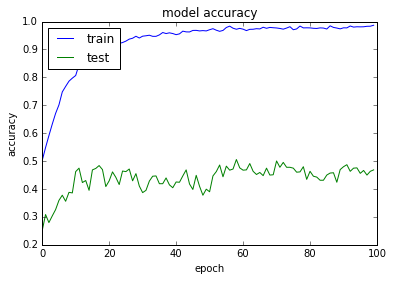

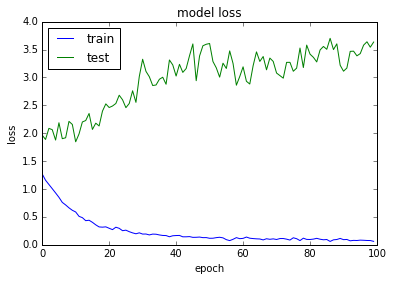

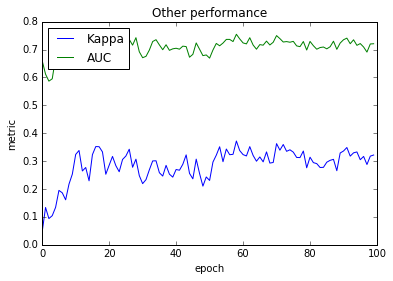

In [ ]:
# Create the model and parameters for training
numpy.random.seed(seed)

batch = 1
epochs = 100

modelA3 = create_LSTM3_PCA(dummy_y_trainA.shape[1], batch_size = batch, trainShape1=n_components)
print modelA3.summary()

# To save the best model
# serialize model to JSON
modelA3_json = modelA3.to_json()
with open("activity.model--3lstmaudio.json", "w") as json_file:
    json_file.write(modelA3_json)
filepathA3="activity.weights--3lstmaudio.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpointA3 = ModelCheckpoint(filepathA3, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_listA3 = [checkpointA3]

# Fit the model
accs =[]
val_accs =[]
losss =[]
val_losss =[]
kappas = []
aucs = []

# Manually create epochs and reset between sessions
for i in range(epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', epochs)
    history = modelA3.fit(trainX, dummy_y_trainA, validation_data=(valX, dummy_y_valA), 
                        nb_epoch=1, batch_size=batch, shuffle=False, 
                        verbose=1, callbacks=callbacks_listA3)
    modelA3.reset_states()
    kappa, auc = printValStats(modelA3, valX, dummy_y_valA, batch=batch)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])
    kappas.append(kappa)
    aucs.append(auc)
    
print 'Best validation accuracy: ', get_max_values(val_accs)
plot_training(accs, val_accs, losss, val_losss, kappas, aucs)

### Random forest baseline

### SVM baseline

### Baseline + HMM states in the mix
see https://github.com/hmmlearn/hmmlearn and https://github.com/larsmans/seqlearn

# Loading and evaluating the best models

## 3-layer LSTM (Activity)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# LOAD AND USE MODEL
json_file3 = open('activity.model--3lstmbis.json','r')
loaded_model_json3 = json_file3.read()
json_file3.close()
loaded_model3 = model_from_json(loaded_model_json3)

# load weights into new model
loaded_model3.load_weights("activity.weights--3lstmbis.best.hdf5")
print("Loaded model 3 from disk")
# evaluate loaded model on test data
# IMPORTANT: compile the model again before use!
loaded_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score3 = loaded_model3.evaluate(testX, dummy_y_testA, batch_size=1, verbose=0)
print "3 Layer LSTM --- %s: %.2f%%" % (loaded_model3.metrics_names[1], score3[1]*100)
printValStats(loaded_model3,  testX, dummy_y_testA, batch=1)